In [5]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from code_comparison.solps_pp import *

from DLScommonTools import *
from Morph import *
from Postprocess import *
from copy import deepcopy

%matplotlib inline
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read balance file

In [6]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = 200)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
file_write(eqb, "equilibrium.pkl")

In [7]:
eqb = file_read("equilibrium.pkl")
data = eqb["SPR45"] # Pick design to use for study

# Setup and run DLS

In [8]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

# Morph1: Move inner target down to outer target level

In [9]:
%matplotlib inline
plt.close("all")

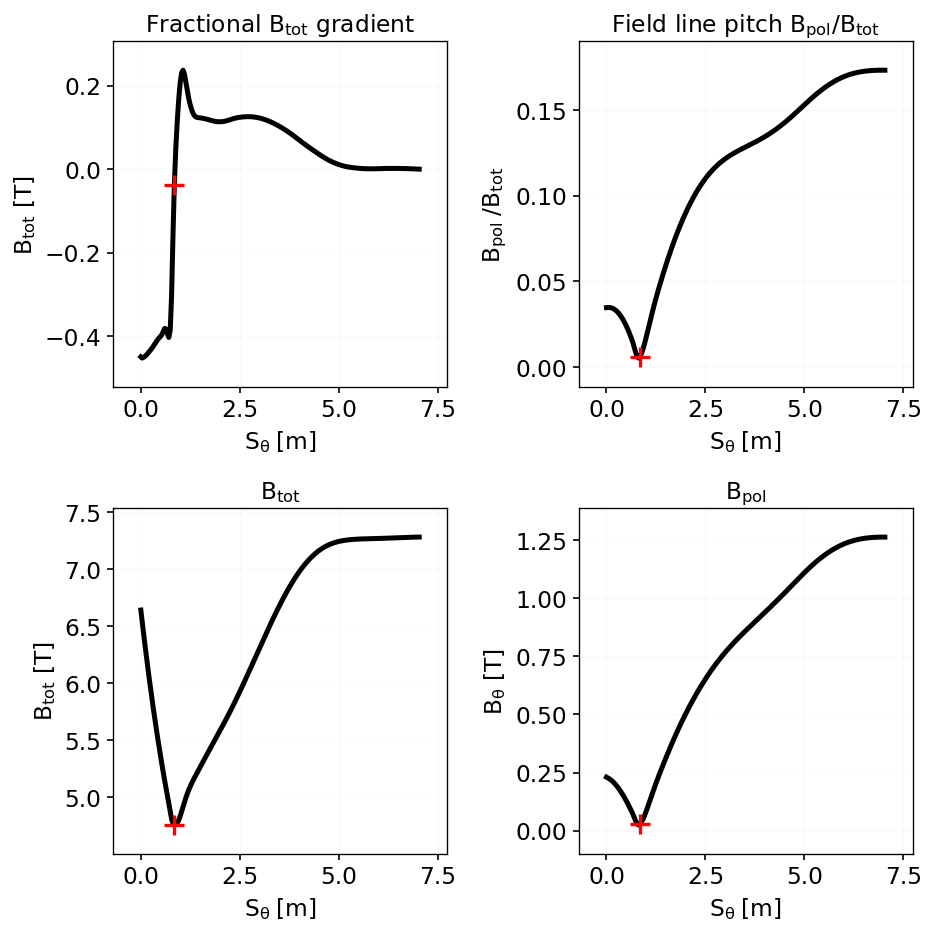

In [10]:
d = eqb["SPR45"]["il"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])

base.plot_topology()

In [11]:
base_offsets = [
    {"pos" : 1},
    {"pos" : 0.97},
    {"pos" : 0.95},
    {"pos" : 0.85},
    {"pos" : 0.7},
    {"pos" : 0.35},
    {"pos" : 0.02},
    {"pos" : 0.0},
    ]

offsets_stage1 = [
    {"pos" : 1,     "offsety": 0},
    {"pos" : 0.97,  "offsety": 0},
    {"pos" : 0.95,  "offsety": 0},
    {"pos" : 0.85,  "offsety": 0},
    {"pos" : 0.7,   "offsety": 0},
    {"pos" : 0.35,  "offsety": -0.2},
    {"pos" : 0.02,  "offsety": -1.5, "offsetx": -0.01},
    {"pos" : 0.0,   "offsety": -1.98},
    ]

offsets_stage2 = [
    {"pos" : 1,     "offsetx": 0},
    {"pos" : 0.97,  "offsetx": 0},
    {"pos" : 0.95,  "offsetx": 0},
    {"pos" : 0.85,  "offsetx": 0.1},
    {"pos" : 0.7,   "offsetx": 0.198},
    {"pos" : 0.35,  "offsetx": 0.298},
    {"pos" : 0.0,   "offsetx": 0.31},
    ]

In [12]:
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
base.offset_control_points(base_offsets)
self = base.copy()
from_offsets = offsets_stage1

## Calculate the new leg RZ from the spline
# Note xs and ys are backwards
dist = get_cord_distance(self["R_leg"], self["Z_leg"])   # Distances along old leg

if from_offsets is not None:
    self.R_control, self.Z_control = shift_points(self.R_leg, self.Z_leg, from_offsets)
    spl = cord_spline(self["R_control"][::-1], self["Z_control"][::-1], return_spline = True)
    
else:
    raise Exception("Must provide offsets to from_offsets")
    
# spl = cord_spline(self["R_leg_spline"][::-1], self["Z_leg_spline"][::-1], return_spline = True)   # Spline interp for new leg
self["R_leg_spline"], self["Z_leg_spline"] = spl(dist)     # New leg interpolated onto same points as old leg

## Calculate total RZ by adding upstream
self["R"] = np.concatenate([
    self["R_leg_spline"],
    self["R"][self["Xpoint"]+1:], 
    ])

self["Z"] = np.concatenate([
    self["Z_leg_spline"],
    self["Z"][self["Xpoint"]+1:], 
    ])

## Calculate poloidal dist and field
self["Spol"] = returnll(self["R"], self["Z"])
self["Bpol"] = self["Bpol"].copy()    # Assume same poloidal field as start

## Calculate toroidal field (1/R)
Btor = np.sqrt(self["Btot"]**2 - self["Bpol"]**2)   # Toroidal field
Btor_leg = Btor[:self["Xpoint"]+1]
Btor_leg_new = Btor_leg * (self["R_leg"] / self["R_leg_spline"])

## Calculate poloidal field (same profile scaled on new Spol)
Bpol_leg = self["Bpol"][:self["Xpoint"]+1]

## Calculate total field (from Btor, Bpol)
Btot_leg_new = np.sqrt(Btor_leg_new**2 + Bpol_leg**2)

self["Btot"] = np.concatenate([
    Btot_leg_new,
    self["Btot"][self["Xpoint"]+1:], 
    ])

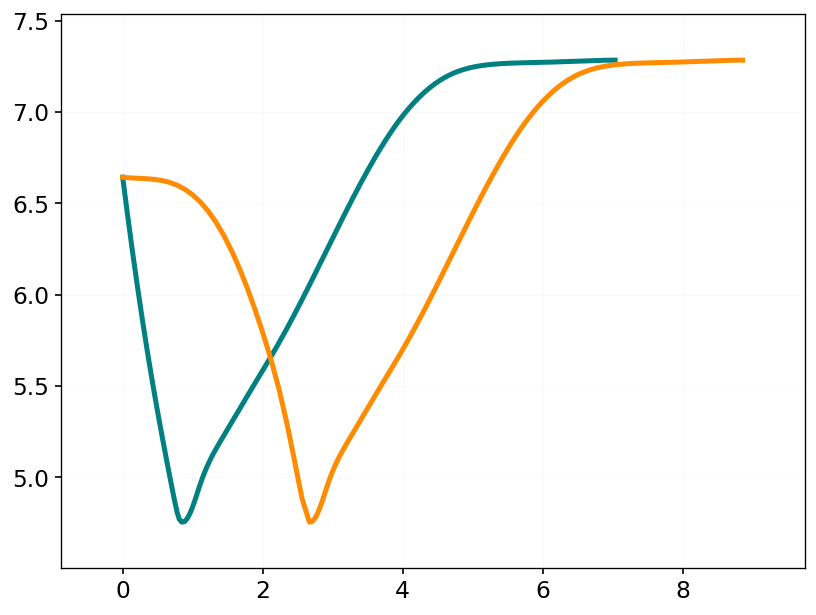

In [13]:
fig, ax = plt.subplots()
for p in [base, self]:
    # ax.plot(p["R_leg_spline"], p["Z_leg_spline"], label = p["name"])
    # ax.plot(p["R"], p["Z"], label = p["name"])
    # ax.plot(p.Spol, p.Bpol)
    ax.plot(p.Spol, p.Btot)

(-9.0, -5.8)

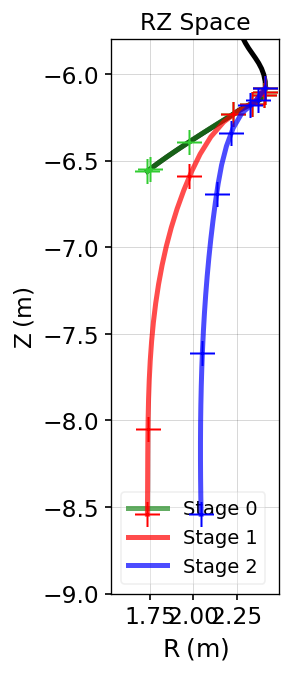

In [14]:
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])

# Make stage 0 by copying the base profile
stage0 = base.copy()
stage0.offset_control_points(base_offsets)
stage0.name = "Stage 0"

# Make stage 1 by offsetting stage 0
stage1 = base.copy()
stage1.offset_control_points(offsets_stage1)
stage1.recalculate_topology()
stage1.name = "Stage 1"

# Make stage 2 by offseting stage 1
stage2 = stage1.copy()
stage2.offset_control_points(offsets_stage2)
stage2.recalculate_topology()
stage2.name = "Stage 2"


fig, ax = plt.subplots()
ax.plot(base.R, base.Z, lw = 3, c = "k")
stage0.plot_control_points(ax = ax)
stage1.plot_control_points(ax = ax, markersettings = {"c" : "r"}, linesettings = {"c" : "r"})
stage2.plot_control_points(ax = ax, markersettings = {"c" : "b"}, linesettings = {"c" : "b"})
ax.legend(fontsize = "small")
ax.set_ylim(-9, -5.8)

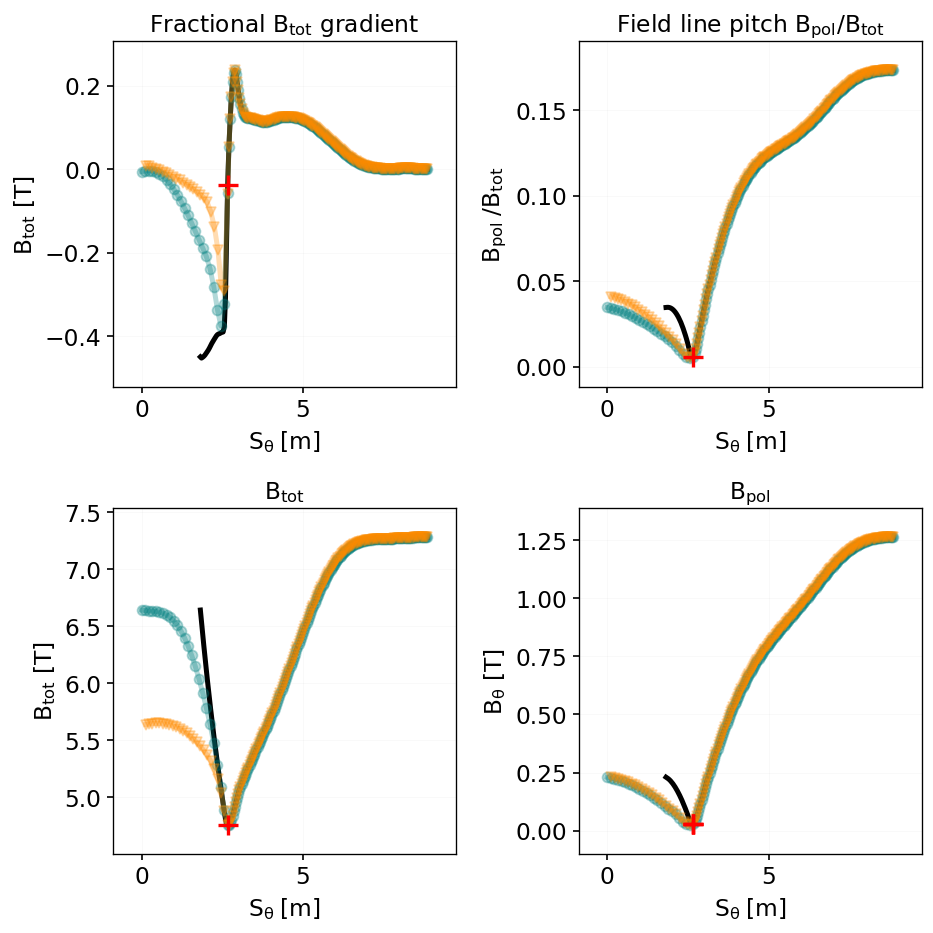

In [15]:
compare_profile_topologies(stage0, [stage1, stage2])

## Morph between any two

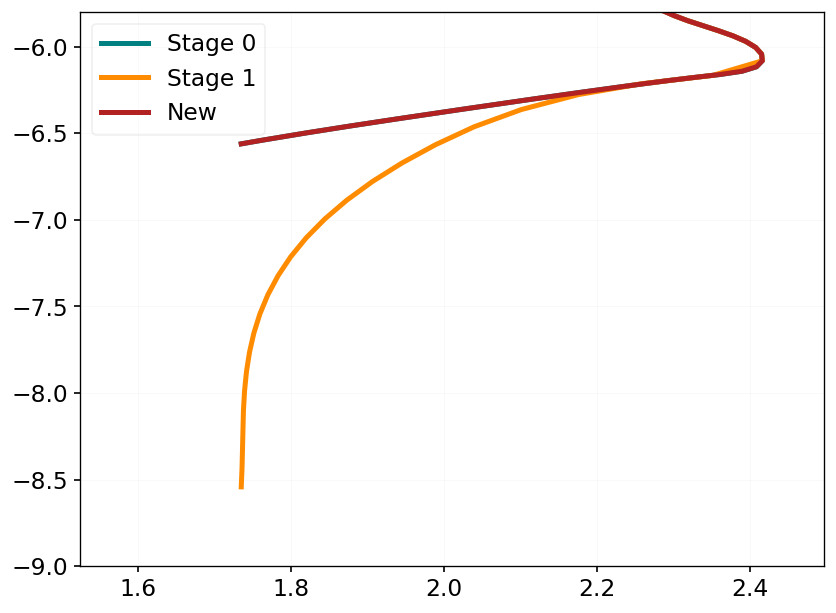

In [16]:
start = stage0.copy()
end = stage1.copy()
new = stage0.copy()
factor = 0

# Make stage 1 by offsetting stage 0
new = base.copy()
new.offset_control_points(offsets_stage1, factor = factor)
new.recalculate_topology()
new.name = "New"


fig, ax = plt.subplots()

for p in [start, end, new]:
    ax.plot(p.R, p.Z, label = p.name)
    


ax.set_ylim(-9, -5.8)
ax.legend()

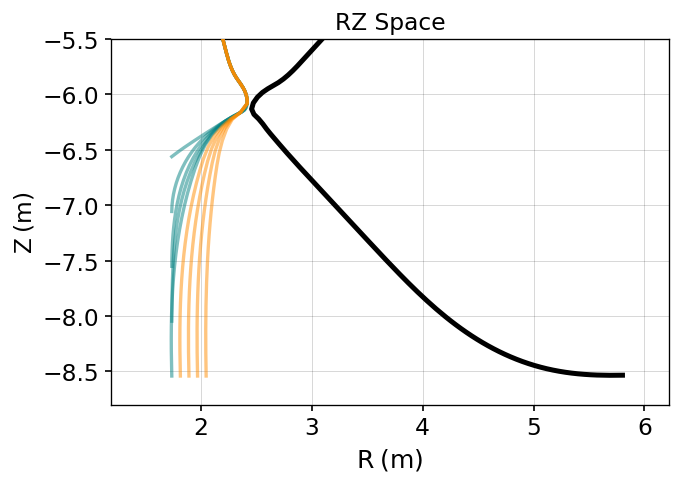

In [17]:
start = stage0.copy()
end = stage1.copy()
new = stage0.copy()
factor = 0

# Make stage 1 by offsetting stage 0
new = base.copy()
new.offset_control_points(offsets_stage1, factor = factor)
new.recalculate_topology()
new.name = "New"

profiles = {}
for i in np.linspace(0,1,5):
    profiles[i] = base.copy()
    profiles[i].offset_control_points(offsets_stage1, factor = i)
    profiles[i].recalculate_topology()
    profiles[i].name = i

for i in np.linspace(1,2,5):
    profiles[i] = stage1.copy()
    profiles[i].offset_control_points(offsets_stage2, factor = i-1)
    profiles[i].recalculate_topology()
    profiles[i].name = i

fig, ax = plt.subplots(1, figsize = (6,12))

profs = {}
for i in profiles:
 
    p = profiles[i]
    
    c = "teal" if i <= 1 else "darkorange"
    
    ax.plot(p.R, p.Z, zorder = 100, alpha = 0.5, lw = 2, ls = "-", c = c)

d_outer = eqb["SPR45"]["ol"]
ax.plot(d_outer["R"], d_outer["Z"], linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)

ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-8.8, -5.5)

alpha = 0.5
ax.set_title("RZ Space")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

In [19]:
cvar = "density"
design = "SPR45"
side = "iu"

store = dict()

    
for i in profiles:
    d = profiles[i].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 10) # Solve at these parallel positions
    
    if "i" in side:
        constants["qpllu0"] = constants_default["qpllu0"] * 1.1 # Reduce power to 10% for the inner divertor to account for power sharing.
    elif "o" in side:
        constants["qpllu0"] = constants_default["qpllu0"] * 2 # Reduce power to 10% for the inner divertor to account for power sharing.

    results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)
    
    store[i] = copy.deepcopy(results)

Solving...0...6...11...15...18...20...21...22...23...24...Complete in 20.5 seconds
Solving...0...6...10...14...18...20...21...22...23...24...Complete in 21.5 seconds
Solving...0...6...10...14...17...20...21...22...23...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


24...Complete in 21.9 seconds
Solving...0...6...11...14...17...20...21...22...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


23...24...Complete in 20.7 seconds
Solving...0...6...11...15...17...19...21...22...23...24...Complete in 21.2 seconds
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.4 seconds
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.3 seconds
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.4 seconds
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 20.2 seconds


C:\Users\mikek\AppData\Local\Temp\ipykernel_22084\1550407324.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Spectral_r', 9)


Text(0.5, 1.0, 'Front position response to upstream density')

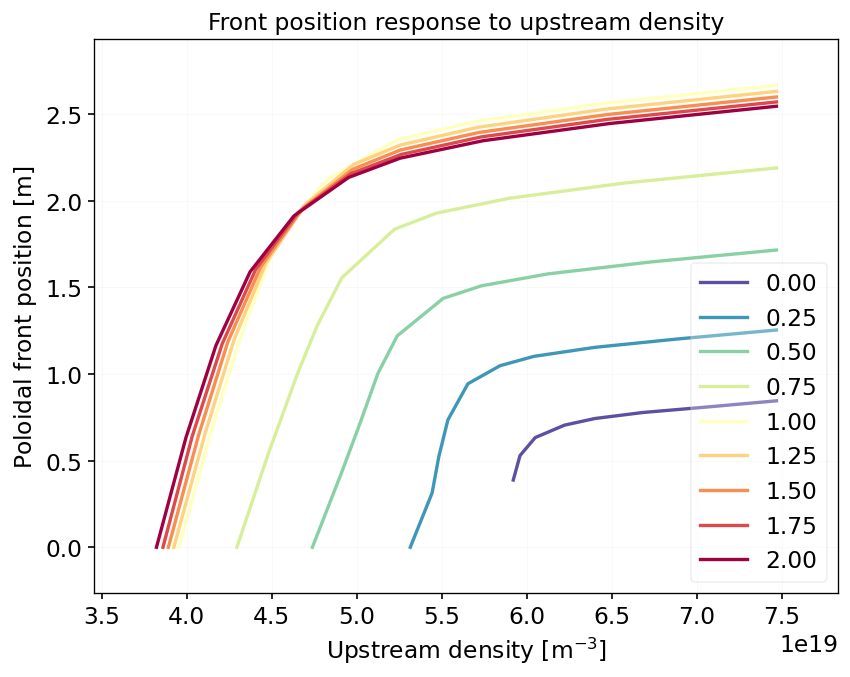

In [23]:
fig, ax = plt.subplots()
style = dict(lw = 2)

cmap = mpl.cm.get_cmap('Spectral_r', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["cvar_trim"], s["SpolPlot"], label = f"{id:.2f}", color = colors[i], **style)
    
ax.legend()
ax.set_xlabel("Upstream density $[m^{-3}]$")
ax.set_ylabel("Poloidal front position $[m]$")
ax.set_title("Front position response to upstream density")
# store2.keys()

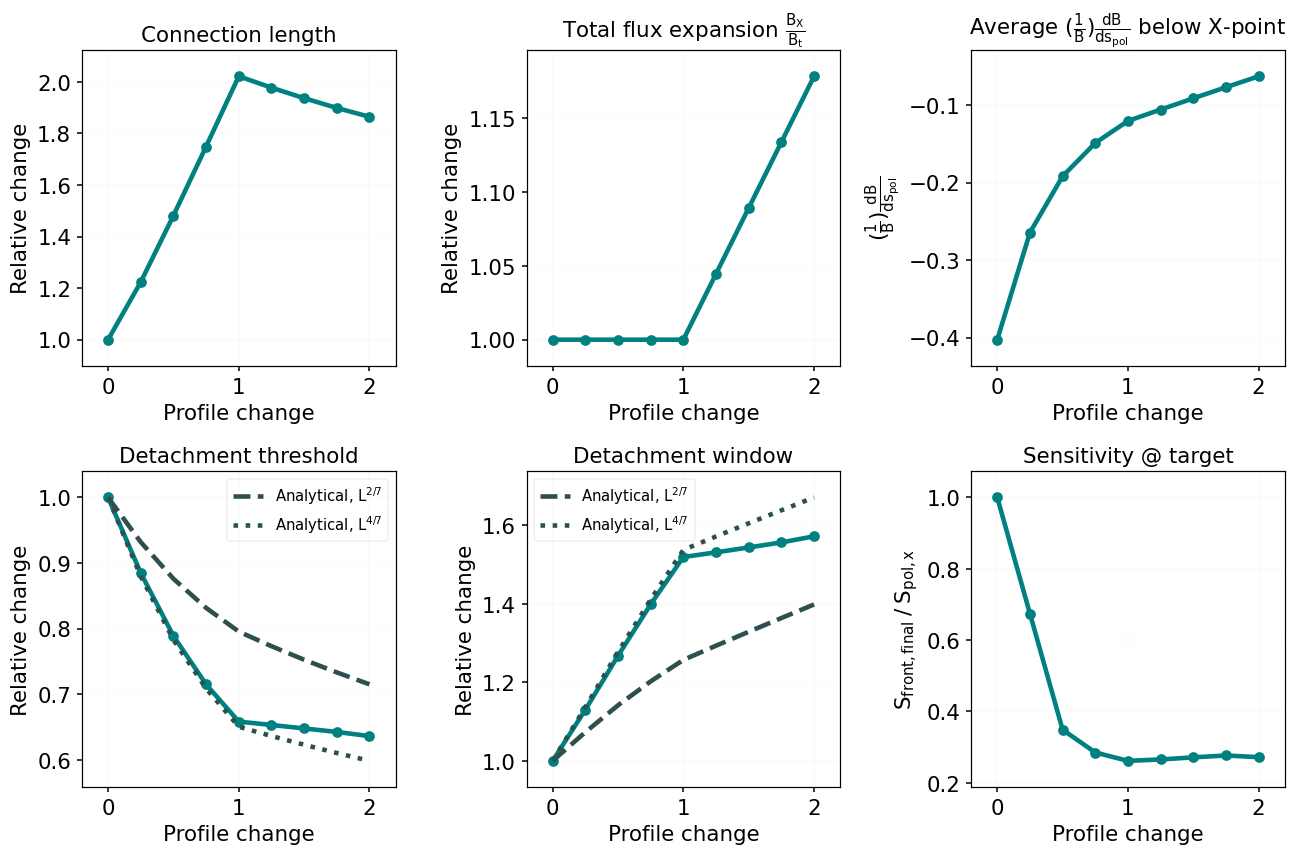

In [24]:
labels = ["Height", "Height and distance"]
colors = ["teal", "darkorange"]

windows = []

fig, axes = plt.subplots(2,3, dpi = 110, figsize = (12,8))


    

windows = np.array([store[x]["window_ratio"] for x in profiles])

thresholds = np.array([store[x]["threshold"] for x in profiles])
L = np.array([profiles[x].get_connection_length() for x in profiles])
BxBt = np.array([profiles[x].get_total_flux_expansion() for x in profiles])
frac_gradB = np.array([profiles[x].get_average_frac_gradB() for x in profiles])
avgB_ratio = np.array([profiles[x].get_average_B_ratio() for x in profiles])

target_sens = np.array([get_sensitivity(store[x]["crel_trim"], store[x]["SpolPlot"], fluctuation=1.05, location=0.0) for x in profiles])

L_base = L[0]
BxBt_base = BxBt[0]
threshold_base = thresholds[0]
window_base = windows[0]
avgB_ratio_base = avgB_ratio[0]
    
threshcalc = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-2/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
threshcalc2 = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-4/7) * (avgB_ratio/avgB_ratio_base)**(2/7)

windowcalc = (BxBt/BxBt_base)**(1) * (L/L_base)**(2/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
windowcalc2 = (BxBt/BxBt_base)**(1) * (L/L_base)**(4/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)

index = profiles.keys()

# index = np.linspace(0,1,5)+i
axes[0,0].set_title("Connection length")
axes[0,0].plot(index, L/L_base, marker = "o")

axes[0,1].set_title(r"Total flux expansion $\frac{B_{X}}{B_{t}}$")
axes[0,1].plot(index, BxBt/BxBt_base, marker = "o")

axes[0,2].set_title(r"Average $(\frac{1}{B}) \frac{dB}{ds_{pol}}$ below X-point")
axes[0,2].plot(index, frac_gradB, marker = "o")

axes[1,0].set_title(r"Detachment threshold")
axes[1,0].plot(index, thresholds/threshold_base, marker = "o")

axes[1,0].plot(index, threshcalc, color = "darkslategrey", ls = "--", label = None if i == 0 else "Analytical, $L^{2/7}$")
axes[1,0].plot(index, threshcalc2, color = "darkslategrey", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$")
axes[1,0].legend(fontsize = "x-small")

axes[1,1].set_title(r"Detachment window")
axes[1,1].plot(index, windows/window_base, marker = "o")
axes[1,1].plot(index, windowcalc, color = "darkslategrey", ls = "--", label = None if i == 0 else "Analytical, $L^{2/7}$")
axes[1,1].plot(index, windowcalc2, color = "darkslategrey", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$")
axes[1,1].legend(fontsize = "x-small")

axes[1,2].set_title(r"Sensitivity @ target")
axes[1,2].plot(index, target_sens, marker = "o")

for ax in axes.flatten():
    ax.set_xlabel("Profile change")

for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]:
    ax.set_ylabel("Relative change")
    
axes[0,2].set_ylabel(r"$(\frac{1}{B}) \frac{dB}{ds_{pol}}$")
axes[1,2].set_ylabel("$S_{front, final} \ /\  S_{pol, x}$")
fig.tight_layout()